<a href="https://colab.research.google.com/github/Artorias1469/NN_2/blob/main/%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE%D1%81%D0%B8%D0%B3%D0%BD%D0%B0%D0%BB%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%D0%94%D0%97_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используя базу "Аудиожанры", примените подход к музыке как к тексту и напишите сверточный классификатор (на базе слоя Conv1D) для подготовленных данных. Для этого:

1. Измените подготовку данных так, чтобы набор признаков, извлекаемый из аудиофайла, был представлен в виде последовательностей векторов признаков. Последовательности должны быть фиксированного размера и выбираться скользящим окном c заданным шагом. Другими словами: берем аудио-файл длительность, например, 30 сек. Берем отрезок фиксированной длины (например, 5с) и получаем набор признаков для этого отрезка. Смещаемся на шаг (например, 1с) и берем следующий отрезок. Таким образом готовим обучающую вборку.
2. Длину последовательности, размер шага и достаточный набор признаков определите самостоятельно исходя из требований к точности классификатора;
3. Разработайте классификатор на одномерных сверточных слоях **Conv1D** с точностью классификации жанра на тестовых данных не ниже **60%**, а на обучающих файлах - **68%** и выше;
4. Используйте за основу материал с урока, но при желании разработайте свои инструменты.

Импортируем необходимые библиотеки:

In [ ]:
# Импорты для работы с данными
import os
import pickle
import zipfile

# Импорты для загрузки данных
import gdown
# Импорты для работы с аудио
import librosa
# Импорты для визуализации
import matplotlib.pyplot as plt
import numpy as np
# Импорты для машинного обучения
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Импорты для нейронных сетей
from tensorflow.keras.layers import (BatchNormalization, Conv1D, Dense,
                                     Dropout, Flatten, Input, MaxPooling1D)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


## Загрузка и распаковка датасета

Датасет с аудиофайлами музыкальных жанров будет скачан из облачного хранилища и распакован в локальную директорию

In [3]:
def download_and_extract(url, output_dir):
    """Скачивает и распаковывает архив с датасетом"""
    # Создаем папку для данных, если ее нет
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Путь для сохранения архива
    zip_path = os.path.join(output_dir, 'dataset.zip')
    
    # Скачиваем архив
    print("Скачивание архива...")
    gdown.download(url, zip_path, quiet=False)
    
    # Распаковываем архив
    print("Распаковка архива...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    
    # Удаляем архив
    os.remove(zip_path)
    print("Датасет готов к использованию")

In [4]:
# Загрузка и распаковка архива
download_and_extract('https://storage.yandexcloud.net/aiueducation/Content/base/l12/genres.zip', 'genres')

Скачивание архива...


Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l12/genres.zip
To: c:\Users\HAIER\Desktop\Задания\Основы нейронных сетей\Занятие 8\nn_lab_8\ДЗ\genres\dataset.zip
100%|██████████| 1.23G/1.23G [03:28<00:00, 5.88MB/s]


Распаковка архива...
Датасет готов к использованию


## Подготовка данных

Для обработки аудиофайлов будем использовать следующие параметры:
- WINDOW_SIZE = 5 сек - размер анализируемого окна
- STEP_SIZE = 1 сек - шаг скользящего окна
- SR = 22050 - частота дискретизации
- N_MFCC = 13 - количество MFCC-коэффициентов

In [ ]:
# Параметры обработки аудио
WINDOW_SIZE = 5       # Длина анализируемого окна в секундах
STEP_SIZE = 1         # Шаг скользящего окна в секундах  
SR = 22050            # Частота дискретизации аудио
N_MFCC = 13           # Количество MFCC-коэффициентов

# Вычисление параметров в сэмплах
samples_per_window = WINDOW_SIZE * SR
step_samples = STEP_SIZE * SR

# Списки для признаков и меток
X = []
y = []

# Путь к данным
genres_path = '/genres'
genres = os.listdir(genres_path)

# Обработка каждого файла
for genre in genres:
    genre_path = os.path.join(genres_path, genre)
    for file in os.listdir(genre_path):
        file_path = os.path.join(genre_path, file)
        
        # Загрузка аудиофайла
        audio, sr = librosa.load(file_path, sr=SR)

        # Извлечение признаков скользящим окном
        for start in range(0, len(audio) - samples_per_window, step_samples):
            window = audio[start:start + samples_per_window]
            
            # Извлечение MFCC-признаков
            mfcc = librosa.feature.mfcc(y=window, sr=sr, n_mfcc=N_MFCC)
            mfcc = mfcc.T
            
            # Проверка размерности и сохранение
            if mfcc.shape[0] == 216:
                X.append(mfcc)
                y.append(genre)

# Преобразование в numpy массивы
X = np.array(X)
y = np.array(y)

print("Размерность признаков:", X.shape)
print("Размерность меток:", y.shape)

Признаки: (25990, 216, 13)
Метки: (25990,)


Перед обучением модели необходимо:
1. Закодировать метки классов
2. Нормализовать признаки
3. Разделить данные на обучающую и тестовую выборки

In [3]:
# Кодировка меток
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Масштабирование признаков
scaler = StandardScaler()
n_samples, n_frames, n_features = X.shape
X_reshaped = X.reshape(-1, n_features)
X_scaled = scaler.fit_transform(X_reshaped).reshape(n_samples, n_frames, n_features)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y_cat)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (20792, 216, 13)
Test shape: (5198, 216, 13)


## Обучение модели и оценка 

Использована сверточная нейронная сеть с архитектурой:
1. Conv1D (64 фильтра) + BatchNorm + MaxPooling + Dropout
2. Conv1D (128 фильтров) + BatchNorm + MaxPooling + Dropout  
3. Полносвязные слои для классификации

In [4]:
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=200, 
                    batch_size=32, 
                    verbose=1)


I0000 00:00:1748215128.637424      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 214, 64)             │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 214, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 107, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 107, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 105, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 105, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6656)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         852,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 881,418 (3.36 MB)

 Trainable params: 881,034 (3.36 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/200


I0000 00:00:1748215133.442935      87 service.cc:148] XLA service 0x7dca6800f270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748215133.443586      87 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748215133.808305      87 cuda_dnn.cc:529] Loaded cuDNN version 90300


 50/650 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2887 - loss: 2.7470

I0000 00:00:1748215137.179475      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


650/650 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4581 - loss: 1.6851 - val_accuracy: 0.6093 - val_loss: 1.5598
Epoch 2/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6300 - loss: 1.0377 - val_accuracy: 0.6972 - val_loss: 1.1181
Epoch 3/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6925 - loss: 0.8594 - val_accuracy: 0.7247 - val_loss: 1.1863
Epoch 4/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7459 - loss: 0.7189 - val_accuracy: 0.7907 - val_loss: 0.7298
Epoch 5/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7737 - loss: 0.6237 - val_accuracy: 0.7691 - val_loss: 0.8972
Epoch 6/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7986 - loss: 0.5569 - val_accuracy: 0.8018 - val_loss: 0.7571
Epoch 7/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8194 - loss: 0.5076 - val_accuracy: 0.8165 - val_loss: 0.7596
Epoch 8/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8350 - loss: 0.4572 - val_accuracy: 0.83

После обучения оценим качество модели:
1. Точность на обучающей и тестовой выборках
2. Графики обучения
3. Матрицу ошибок

Точность на тренировочной выборке: 98.36%
Точность на тестовой выборке: 93.25%


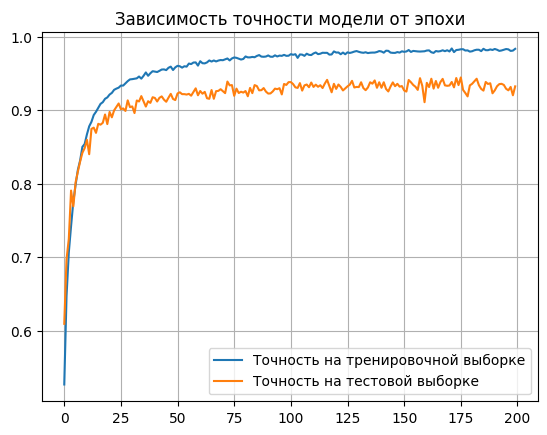

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


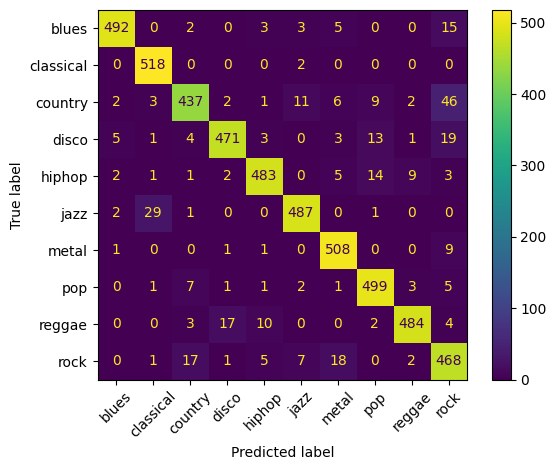

In [5]:
# Точность
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Точность на тренировочной выборке: {train_acc:.2%}")
print(f"Точность на тестовой выборке: {val_acc:.2%}")

# График обучения
plt.plot(history.history['accuracy'], label='Точность на тренировочной выборке')
plt.plot(history.history['val_accuracy'], label='Точность на тестовой выборке')
plt.title("Зависимость точности модели от эпохи")
plt.legend()
plt.grid()
plt.show()

# Матрица ошибок
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.show()
